# Module 2.- EDA

In [1]:
import pandas as pd
import os
import pyarrow
import contextlib
import io
import matplotlib.pyplot as plt 
import json
from collections import Counter

# Ex 1

## Load BDD 

In [2]:
PATH = '../../data/'
parquet_files = ["abandoned_carts.parquet","inventory.parquet","orders.parquet", "regulars.parquet", "users.parquet"]

def get_info_middle(df):
    fobj = io.StringIO()
    with contextlib.redirect_stdout(fobj) as stdout:
        df.info()
    fobj.seek(0)
    return '\n'.join(fobj.read().splitlines()[3:-2])

abandoned_carts = pd.read_parquet(PATH + parquet_files[0], engine='pyarrow')
inventory = pd.read_parquet(PATH + parquet_files[1], engine='pyarrow')
orders = pd.read_parquet(PATH + parquet_files[2], engine='pyarrow')
regulars = pd.read_parquet(PATH + parquet_files[3], engine='pyarrow')
users = pd.read_parquet(PATH + parquet_files[4], engine='pyarrow')

In [ ]:
print('#####Abandoned######\n#####')
print(abandoned_carts.info())
print('#####Shape######')
print(abandoned_carts.shape)

print('#####Inventory#####\n#####')
print(inventory.info())
print('#####Shape######')
print(inventory.shape)

In [ ]:

print('#####Orders######\n#####')
print(orders.info())
print('#####Shape######')
print(orders.shape)

print('#####Regulars#####\n#####')
print(regulars.info())
print('#####Shape######')
print(regulars.shape)

In [ ]:
print('#####Users#####\n#####')
print(users.info())
print('#####Shape######')
print(users.shape)

Los datatypes de cada variable son correctos. La unica tabla que contiene Nulls es la de Users, las variables que describen al grupo de usuarios de compra (People, Adults, Children, Babies, Pets), donde People es la que engloba a las demás (sin contar Pets). Para las tablas de ordenes/abandonados los productos se identifican entre comas ','. Vamos a comprobar que no haya duplicidades en registros que deberian ser unicos. 

In [ ]:
def unique_val(dataframe, columna):
    return dataframe[columna].nunique() == dataframe.shape[0]
print('#####Abandoned######')
print(unique_val(abandoned_carts, 'id'))
print('#####Inventoy######')
print(unique_val(inventory, 'variant_id'))
print('#####Orders######')
print(unique_val(orders, 'id'))
print('#####Regulars######')
print(unique_val(regulars, 'user_id'))
print('#####Users######')
print(unique_val(users, 'user_id'))

Con esto Podemos ver que un usuario puede pedir mas de un item como consumo habitual. Comprobaremos tmabien que todos los items del inventario estan en alguna de las tablas que contenga items, es decir, no hay itmes que no estan registrados (el primer nuemro de la lista del diccionario es los items de la tabla key y el segundo numero son los itmes para la tabla inventario)

In [4]:
def check_items(orders_df, regulars_df, abandoned_carts_df, inventory_df):
    items_inventory = inventory_df['variant_id'].unique()

    orders_df = orders_df.explode('ordered_items')
    abandoned_carts_df = abandoned_carts_df.explode('variant_id')
    items_orders = orders_df['ordered_items'].unique()
    items_regulars = regulars_df['variant_id'].unique()
    items_abandoned_carts = abandoned_carts_df['variant_id'].unique()
    problemas = {}
    if len(items_orders) > len(items_inventory):
        problemas['orders'] = [len(items_orders), len(items_inventory)]
    else:
        problemas['orders'] = 'correcto'    
    if len(items_regulars) > len(items_inventory):
        problemas['regulars'] = [len(items_regulars), len(items_inventory)]
    else:
        problemas['regulars'] = 'correcto'
    if len(items_abandoned_carts) > len(items_inventory):
        problemas['abandoned_carts'] = [len(items_abandoned_carts), len(items_inventory)]
    else:
        problemas['abandoned_carts'] = 'correcto'
    return problemas

resultados = check_items(orders_df= orders, regulars_df=regulars, abandoned_carts_df=abandoned_carts, inventory_df=inventory)
print(resultados)

{'orders': [2117, 1733], 'regulars': [1843, 1733], 'abandoned_carts': 'correcto'}


Para las tablas orders y regulars encontramos items que no estan registrados en el inventario y será dificil trackear sus nombres, tipo y propiedades. Hay un 18% de items no trackeados en Orders y un 5% en Regulars.  Esto puede ser debido a un problema al identificar los productos al pasarlos por el lector, que sean items que se externalizan a proveedores no registrados o tambien que un mismo item esté identificado dos veces. Se tendrá en cuenta en prompts siguentes. Idealmente haremos lo mismo para los usuarios.

In [ ]:
def check_users(users_df, orders_df, regulars_df, abandoned_carts_df):
    check_users = users_df['user_id'].unique()
    check_orders = orders_df['user_id'].unique()
    check_regulars = regulars_df['user_id'].unique()
    check_abandoned_carts = abandoned_carts_df['user_id'].unique()
    problemas = {}
    if len(check_orders) > len(check_users):
        problemas['orders'] = [len(check_orders), len(check_users)]
    else:
        problemas['orders'] = 'correcto'    
    if len(check_regulars) > len(check_users):
        problemas['regulars'] = [len(check_regulars), len(check_users)]
    else:
        problemas['regulars'] = 'correcto'
    if len(check_abandoned_carts) > len(check_users):
        problemas['abandoned_carts'] = [len(check_abandoned_carts), len(check_users)]
    else:
        problemas['abandoned_carts'] = 'correcto'
    return problemas

resultados = check_users(users_df=users, orders_df=orders, regulars_df=regulars, abandoned_carts_df=abandoned_carts)
print(resultados)

Los usuarios estan, por contra, todos identificados.

## EDA - Productos

A continuación se presentan algunas hipótesis o análisis descriptivo de los datos que pretenden responder a ciertas preguntas para entender mejor el negocio.

### Items más vendidos

En esta seccion obtendremos un head de los items más y menos vendidos y las clase de item más vendido (en toda la historia de la tienda) con el promedio de ítems de un carrito de compra

In [ ]:
def most_item(orders_df, inventory_df):
    len1 = len(orders)
    orders_df = orders_df.explode('ordered_items')
    len2 = len(orders_df)
    avg_items_cart = len2/len1
    item_counts = orders_df['ordered_items'].value_counts().reset_index()
    item_counts.columns = ['Item_ID', 'Cantidad']
    merged_df = item_counts.merge(inventory_df, left_on='Item_ID', right_on='variant_id', how='left')
    return merged_df, avg_items_cart

result1, avg_items = most_item(orders_df=orders, inventory_df=inventory)
print('Los items mas vendidos en la histira de la tienda son:')
print(result1.loc[:,['Item_ID', 'Cantidad', 'price', 'vendor', 'product_type', 'tags']].head(10))
print('\n')
print(f'Un carrito tiene {avg_items:.2f} ítmes en promedio')

In [ ]:
print(result1.loc[:,['Item_ID', 'Cantidad', 'price', 'vendor', 'product_type', 'tags']].tail(10))

Los productos no registrados aparecen entre los más y menos vendidos y es un problema no poder identificarlos. Es probable que, al ser un historico el dataset, haya habido un renombre de productos. El producto más vendido es leche de avena Oatly y el que menos una afeitadora Gillette (de los que tenemos registro). Podemos cuestionar seguir vendiendolas (teniendo encuenta que es solo un exploratory data-analysis). Los prosuctos mas vendidos por tipo de producto:

In [ ]:
most_product = result1.groupby('product_type')['product_type'].count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
most_product.plot.bar(x='product_type', y='count')
plt.xticks(fontsize=6)
plt.show()

Vemos que los productos mas vendidos (sin contar aquellos no trackeados) son productos de limpieza y productos de comida preparada (cuidado del hogar), lo que se esperaría en el sector de bienes de consumo. Podemos identificar que la tienda tiene un sesgo en productos eco y bio que suelen ser más caros que productos estándar. Podríamos apropximar en cierta medida esta hipótesis mediante la columna "compare_at_price" que indica (suposición) el precio del prodcuto antes de aplicar un descuento. Comprobaremos el ranking de tipos de productos más rebajados.

In [ ]:
def calcular_ranking_rebajas(inventory):
    inventory['rebaja_absoluta'] = inventory['compare_at_price'] - inventory['price']
    inventory['rebaja_relativa'] = ((inventory['compare_at_price'] / inventory['price']) - 1) * 100
    grouped = inventory.groupby('product_type').agg({
        'rebaja_absoluta': 'mean',
        'rebaja_relativa': 'mean'
    }).reset_index()

    grouped['ranking_absolutos'] = grouped['rebaja_absoluta'].rank(ascending=False).astype(int)
    grouped['ranking_relativos'] = grouped['rebaja_relativa'].rank(ascending=False).astype(int)
    grouped = grouped.sort_values(['ranking_relativos'], ascending=[True])
    grouped = grouped.rename(columns={
        'product_type': 'Tipo de Producto',
        'ranking_absolutos': 'Ranking Absolutos',
        'rebaja_absoluta': 'Rebaja Absoluta Promedio',
        'ranking_relativos': 'Ranking Relativos',
        'rebaja_relativa': 'Porcentaje de Rebaja Promedio'
    })

    return grouped[['Tipo de Producto', 'Ranking Relativos', 'Porcentaje de Rebaja Promedio', 'Ranking Absolutos', 'Rebaja Absoluta Promedio']]

# Ejemplo de uso
discount = calcular_ranking_rebajas(inventory = inventory)
print(discount.head())

Los productos mas rebajados son del tipo crema solar y salsa de cocina (casi a la mitad de precio). El descuento de la crema solar implica cobrar 3.3$ menos en promedio por ese tipo de producto y el descuento de las salsas de implica una perdida de 0.46$ promedia por ese tipo de producto. Suponiendo que el dataset fue recogido el 14/03/2022 (ultimo día en el que se recibió un Order), parece una mala politica rebajar la crema solar en invierno (en caso que quiera venderse mas en verano)

### Cesta promedio

In [ ]:
def common_cart(orders_df, inventory_df):
    orders_mod = orders_df.copy()
    orders_mod['cesta'] = orders_mod['ordered_items'].astype(str)

    cestas_contadas = orders_mod.groupby('cesta').size().reset_index(name='cantidad')
    cesta_mas_comun = cestas_contadas.loc[cestas_contadas['cantidad'].idxmax()]
    cesta_text = pd.DataFrame({'Cesta':[int(e) for e in cesta_mas_comun['cesta'].strip('[]').split()]})
    
    #cONTAMOS cantidad productos
    cesta_con_cantidad = cesta_text.groupby('Cesta').size().reset_index(name='cantidad')
    cesta_con_precios = cesta_con_cantidad.merge(inventory_df, left_on='Cesta', right_on='variant_id', how='left')
    cesta_con_precios['precio_total'] = cesta_con_precios['cantidad'] * cesta_con_precios['price']

    return cesta_con_precios
nombres_cesta = common_cart(orders_df=orders, inventory_df=inventory)
print("Cesta Promedio:\n", nombres_cesta)

La cesta mas comun son cuatro bricks de leche Oatly por un precio total de 43.16$. Evaluaremos tambien en el timpo la cesta promedio. Como hipotesis inicial pensaríamos que la cesta promedio debería ser constante en el tiempo

In [ ]:
def common_cart_chart(orders_df):
    orders_df = orders_df.explode(column='ordered_items', ignore_index=True)
    orders_df = orders_df.groupby(['order_date', 'id'])['ordered_items'].count().reset_index()
    month_avg_items = orders_df.groupby(orders_df['order_date'].dt.to_period("M"))['ordered_items'].mean().reset_index()
    
    plt.figure(figsize=(9, 5))
    month_avg_items.plot(marker='.', linestyle='-')
    plt.xlabel('Month')
    plt.ylabel('Avg Cart Size')
    plt.title('Cesta promedio')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

common_cart_chart(orders_df=orders)

Rechazamos H0, la cesta promedio baja desde el inicio de la primera compra de la tienda. Deberíamos mirar si el precio promedio al menos se mantiene constante y son los consumidores quienes han cambiado la composición de la cesta, pero como no tenemos información de ítems no trackeados el resultado se vería distorsionado. Repetiremos el grafico solo para cestas de las que disponemos info y en prompts posteriores investigaremos sobre la perdida de trackeo de ítems.

In [ ]:
def common_cart_inventory(orders_df, inventory_df):
    orders_df = orders_df.explode(column='ordered_items', ignore_index=True)
    orders_inventory = orders_df.merge(inventory_df, left_on='ordered_items', right_on='variant_id', how='inner')
    orders_inventory['order_date'] = pd.to_datetime(orders_inventory['order_date'])
    orders_inventory = orders_inventory.groupby(['order_date', 'id'])['ordered_items'].count().reset_index()
    orders_inventory['month'] = orders_inventory['order_date'].dt.to_period('M')
    #orders_inventory['ordered_items'] = pd.to_numeric(orders_inventory['ordered_items'])
    month_avg_items = orders_inventory.groupby('month')['ordered_items'].mean()

    plt.figure(figsize=(9, 5))
    month_avg_items.plot(marker='.', linestyle='-')
    plt.xlabel('Month')
    plt.ylabel('Avg Cart Size')
    plt.title('Cesta promedio')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
common_cart_inventory(orders_df=orders, inventory_df=inventory)

la cesta de ítems si trackeados cumple aproximadamente H0, exceptuando los primeros meses. Esto indica que los primeres meses de la base de datos Orders el data-walmart no registraba los ítmes en el inventario o que por el camino ha ido eliminandolos/renombrandolos (mala praxis).

### Evolucion ordenes

In [ ]:
def plot_series_temporales(orders_df):
    orders_df = orders_df.explode('ordered_items')
    monthly_orders = orders_df.groupby(orders_df['order_date'].dt.to_period('M')).size()
    monthly_items_sold_df = pd.DataFrame({'Month': monthly_orders.index.to_timestamp(), 'Items Sold': monthly_orders.values})
    monthly_items_sold_df = monthly_items_sold_df.sort_values(by='Month')

    plt.figure(figsize=(9, 5))
    plt.plot(monthly_items_sold_df['Month'], monthly_items_sold_df['Items Sold'], marker='o', linestyle='-')
    plt.xlabel('Month')
    plt.ylabel('Items Sold')
    plt.title('Monthly Items Sold')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_series_temporales(orders_df=orders)

La evolucion de ventas fue creciente estos años. A finales de cada año hay un spike en las ventas, posiblemente debido a alguna campaña publicitaria en esos periodos. No se observa estacionalidad, pero si mucha volatilidad a partir de Septiembre 2021. Las ordenes bajan considerablemente el ultimo mes, pero puede ser debido a que la muestra acaba el 14/03/2022 y todavia no tenemos desboqueados los datos de todo el mes.

Por úlitmo en lo referente a ordenes podemos ver la frecuencia de ordenes entre los usuarios

In [ ]:
def freq_orders(orders_df):
    count_user_order_seq = orders_df['user_order_seq'].value_counts()
    plt.figure(figsize=(10, 6))
    count_user_order_seq.plot(kind='bar')
    plt.title('Recuento de ocurrencias de user_order_seq')
    plt.xlabel('Valor de user_order_seq')
    plt.ylabel('Recuento de ocurrencias')
    plt.xticks(rotation=90)
    plt.show()
freq_orders(orders_df=orders)

Parece que lo que podría ser un proxy al retention rate es bastante bajo. La mayoría de ordenes son de usuarios que hasta el momento no han vuelto a comprar. El máximo de ordenes de un usuario es 25 (solo ocurre en 1 usuario)

## EDA - Users

A continuación se presentan algunas hipótesis o análisis descriptivos de los usuarios que pretenden responder a ciertas preguntas para entender mejor el negocio.

### Descriptiva de los usuarios

In [ ]:
def user_desc(user_df):
    count_user_segment = user_df['user_segment'].value_counts()
    count_user_nuts1 = user_df['user_nuts1'].value_counts()
    plt.figure(figsize=(10, 5))
    pctdistance = 0.5

    plt.subplot(1, 2, 1)
    plt.pie(count_user_segment, labels=count_user_segment.index, autopct='%1.1f%%', startangle=90, pctdistance=pctdistance)
    plt.title('Porcentaje de user_segment')
    plt.subplot(1, 2, 2)
    plt.pie(count_user_nuts1, labels=count_user_nuts1.index, autopct='%1.1f%%', startangle=90, pctdistance=pctdistance)
    plt.title('Porcentaje de user_nuts1')

    plt.tight_layout()
    plt.show()
user_desc(user_df=users)

In [63]:
def non_empty_user(user_df):
    total_users = len(user_df)
    non_empty_cells = user_df['count_people'].count()
    return (non_empty_cells / total_users) * 100
print(f'{non_empty_user(user_df=users):.2f}%')

6.52%


Los usuarios están bastante balanceados en términos de user segment y un 54% pertenecen a las categorías (espaciales) ULI, UKJ, UKK. Recordemos que el unico df con NaN era, de Users, las columnas que describen al usuario (posiblemente usuarios sin cuenta en la tienda online o que no han completado sus perfiles). Los usuarios que completan los campos son un 6.52% del total, por lo que al establecer hipotesis los contrastes no serán representativos. En el apartado siguiente obtendremos una frecuencia de los tipos de users.   

In [ ]:
def create_user_type_dict(users_df):
    users_df = users_df.dropna(subset=['count_people'])
    user_type_dict = {}
    
    for index, row in users_df.iterrows():
        user_type_str = f"count_adults_{row['count_adults']}_count_children_{row['count_children']}_count_babies_{row['count_babies']}_count_pets_{row['count_pets']}"
        user_type_dict[user_type_str] = user_type_dict.get(user_type_str, 0) + 1
    sorted_user_type_dict = dict(sorted(user_type_dict.items(), key=lambda x: x[1], reverse=True))
    return sorted_user_type_dict
print(json.dumps(create_user_type_dict(users_df=users), indent=2))

El usuario mas comúnm (de ese 6.52%) es un usuario con 2 adultos (58 users), seguido de un solo adulto (50 users). El usuario 'familia estandar' (2 adultos, 2 niños y 1 mascota) es el tercer tipo de user mas frecuente (25 users). En general hay pocas familias con bebés, pero suponiendo que estratificamos la muestra de users con descripcion a la poblacion de 'user', interesa cubrir productos para bebés. (Bonus: Hay 2 users que son solo mascotas jeje)

### Inscripción de Users

Comprobaremos el registro de usuarios en el tipo segun user_segment. Es ua categoria balanceada pero podremos identificar si algun tipo de segmento de usuario fue incorporado despues en la tienda  veremos como ha sido su ritmo de incorporacion

In [ ]:
def inc_users(user_df):
    user_df['first_ordered_at'] = pd.to_datetime(user_df['first_ordered_at'])
    plt.figure(figsize=(9, 5))
    for segment in user_df['user_segment'].unique():
        customer_acq = user_df[user_df['user_segment'] == segment].resample('M', on='first_ordered_at')['user_id'].count()
        customer_acq.plot(kind='line', marker='.', label=segment)
    plt.xlabel('Time')
    plt.ylabel('Customers')
    plt.title('Evolucion Users time')
    plt.legend()
    plt.show()
inc_users(user_df=users)

Rechazamos H0, ya que no parece haber diferencia en el ritmo de incorporación de usuarios entre user_segment. Los usuarios siguen una tendencia alcista y se diferencias tres estratos: [Apr_20:Dec_20]; [jan_21:Sep_21]; [Oct_22:Today]. Similar al gráfico de órdenes ha habido un Spike lo importante de nuevos usuarios en Septiembre de 2021, por lo que algún patrocinio ayudó a expandir el nombre de la tienda. Se repite la bajada drástica de nuevos usuarios para los dos segmentos el último mes, pero como hemos dicho anteriormente, de los datos de todo el mes todavía no han sido recogidos.

## EDA - Regulars

Miraremos los users con mas reservas, los items mas reservados y contrastaremos H0: los users con items guardados compran mas que los usuarios sin listar items regulares

In [ ]:
def users_regulars_frec(regulares_df):
    # Primer gráfico de barras - user_id
    user_counts = regulares_df['user_id'].str[:4].value_counts().head(10)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    user_counts.plot(kind='bar')
    plt.title('Recuento de reservas por user_id (primeras 4 letras)')
    plt.xlabel('user_id (primeras 4 letras)')
    plt.ylabel('Recuento de reservas')

    # Segundo gráfico de barras - variant_id
    variant_counts = regulares_df['variant_id'].value_counts().head(10)
    plt.subplot(1, 2, 2)
    variant_counts.plot(kind='bar')
    plt.title('Recuento de reservas por variant_id')
    plt.xlabel('variant_id')
    plt.ylabel('Recuento de reservas')

    plt.tight_layout()
    plt.show()
users_regulars_frec(regulares_df=regulars)

Hay un usuario con mas de 700 items reservados y el item mas reservado con diferencia es una salsa Heinz, con mas de 250 reservas.

In [89]:
def count_orders_by_reservation(orders_df, regulars_df):
    unique_reserved_users = regulars_df['user_id'].unique()
    merged_df = orders_df[orders_df['user_id'].isin(unique_reserved_users)]
    orders_by_reserved_users = len(merged_df)
    orders_by_non_reserved_users = len(orders) - orders_by_reserved_users
    
    result_dict = {
        'orders_by_reserved_users': orders_by_reserved_users,
        'orders_by_non_reserved_users': orders_by_non_reserved_users
    }
    return result_dict
print(count_orders_by_reservation(orders_df=orders, regulars_df=regulars))

{'orders_by_reserved_users': 4025, 'orders_by_non_reserved_users': 4748}


Los usuarios que tiene ítems regulares no compran mas que el resto de usuarios, ya que han hehco el 45% de las ordenes

## ## EDA - Abondoned

Como hipotesis inicial podríamos plantear que los usuarios con hijos (childre) son los que más abandonan carritos, ya que el hijo puede formar una cesta que luego el padre decida no comprar o cambiar los productos

In [9]:
def users_abnadoned(abandoned_carts_df, users_df):
    users_with_children = users_df[users_df['count_children'] > 0]
    users_with_abandoned_carts = abandoned_carts_df['user_id'].unique()
    pct = (
        len(users_with_children[users_with_children['user_id'].isin(users_with_abandoned_carts)]) /
        len(users_with_children)
    ) * 100
    return pct
# Mostrar el resultado
print(f"Número de usuarios con hijos que han abandonado carritos: {users_abnadoned(abandoned_carts_df=abandoned_carts, users_df=users):.2f}%")

Número de usuarios con hijos que han abandonado carritos: 52.31%


teniendo en cuenta que el numero de usuarios con hijos del df de usuarios es practicamente residual, podemos afirmar que la hipotesis se cumple: los usuarios con hijos tienden a abandonar mas carritos

Podemos comprobar si especialmente se abandonan más carritos de compra en navidad.

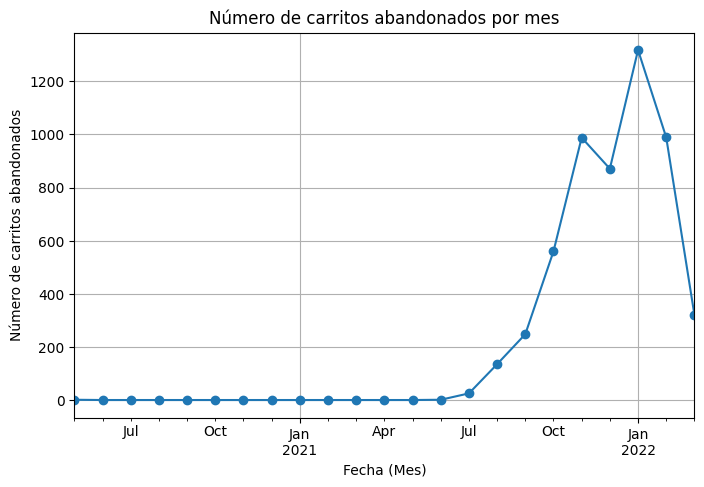

In [11]:
def chart_abandoned(abandoned_carts_df):
    abandoned_carts_df['created_at'] = pd.to_datetime(abandoned_carts_df['created_at'])
    monthly_counts = abandoned_carts.resample('M', on='created_at').size()

    plt.figure(figsize=(8, 5))
    monthly_counts.plot(kind='line', marker='o')
    plt.xlabel('Fecha (Mes)')
    plt.ylabel('Número de carritos abandonados')
    plt.title('Número de carritos abandonados por mes')
    plt.grid(True)
    plt.show()
chart_abandoned(abandoned_carts_df=abandoned_carts)

Parece que el número de carritos abandonados es nulo antes de julio de 2021, y crece exponencialmente después. Esto podría indicar que estas fichas de la página web fue habilitada entonces